# Assignment 5
**CS283 Computer Vision, Harvard University, Fall 2019**

**Due Wednesday, Oct. 16, at 5:00pm**

Name: *Natalia Pacheco-Tallaj*

---

Edges, corners, and multi-resolution representations are the topics covered in this assignment. As usual, the assignment will be submitted via canvas and formatted according to
the guidelines.

In [1]:
# Run this cell (only once) to install the unzip command.
# If you already installed this for previous assignments, no need to reinstall.
! sudo apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following packages were automatically installed and are no longer required:
  libpython3.6-dev linux-aws-headers-4.15.0-1040 linux-aws-headers-4.15.0-1044
  linux-aws-headers-4.15.0-1048
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 139 not upgraded.


In [2]:
# Extract required pset folders (make sure you ran the first cell first)
! unzip pset5.zip

Archive:  pset5.zip
  inflating: data/calib_right.bmp    
   creating: figs/


In [24]:
# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import scipy.signal                      # Signal package from scipy for convolution
import scipy.interpolate                 # Interpolation, used for question 2
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting, used for the code block in question 3

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

## Question 1 (10 points)

In class we derived a finite-difference
approximation to the derivative of the univariate function $f(x)$ by
considering the Taylor polynomial approximations of $f(x+ h)$ and
$f(x-h)$. We showed that
\begin{equation*}
f'(x)=\frac{f(x+h)-f(x-h)}{2h}+O(h^2),
\end{equation*}
so that the derivative can be approximated by convolving a discrete
version of $f(x)$&mdash;a vector of values $[\ldots,f(x_o-\Delta),\
f(x_o),\ f(x_o+\Delta),\ldots]$&mdash;with kernel $[1/2,0,
-1/2]$.  This is termed a *central difference* because its
interval is symmetric about a sample point.

**a.** Derive a higher order central-difference approximation to
$f'(x)$ such that the truncation error tends to zero as $h^4$ instead
of $h^2$.

_Hint: consider Taylor polynomial approximations of
$f(x\pm 2h)$ in addition to $f(x\pm h)$._

### Answer:
If we Taylor expand $f(x\pm 2h)$ about $x$, we get
\begin{align*}
    f(x + 2h) &= f(x) + f'(x) (x + 2h - x) + \frac{f''(x)}{2}(x + 2h - x)^2 + \frac{f'''(x)}{6}(x + 2h - x)^3+ O(h^4)\\
        &= f(x) + f'(x) 2h + \frac{f''(x)}{2}4h^2 + \frac{f'''(x)}{6}8h^3 + O(h^4)\\
    f(x - 2h) &= f(x) + f'(x) (x-2h-x) + \frac{f''(x)}{2} ( x - 2h - x)^2 + \frac{f'''(x)}{6}(x - 2h - x)^3+  O(h^4)\\
        &= f(x) - f'(x)2h + \frac{f''(x)}{2}4h^2 -\frac{f'''(x)}{6}8h^3+ O(h^4) 
\end{align*}
If we subtract both equations, the $f(x)$ terms and $\frac{f''(x)}{2} 4h^2$ cancel, so we get
\begin{align*}
    f(x+ 2h) - f(x - 2h) = 4hf'(x) + 16h^3\frac{f'''(x)}{6} + O(h^4)
\end{align*}
Now if we do the taylor expansions for $f(x\pm h)$ about $x$ we get
\begin{align*}
    f(x+ h) &= f(x) + f'(x)h + \frac{f''(x)}{2}h^2 + \frac{f'''(x)}{6}h^3 + O(h^4)\\
    f(x-h) &= f(x)  - f'(x)h + \frac{f''(x)}{2}h^2 - \frac{f'''(x)}{6}h^3 + O(h^4)
\end{align*}
Subtracting them we have
$$f(x+h) - f(x-h) = 2hf'(x) + 2h^3\frac{f'''(x)}{6} + O(h^4)$$
Then we have that
\begin{align*}
    f(x+ 2h) - f(x - 2h)  - 8(f(x+h) - f(x-h)) &= 4hf'(x) + 16h^3\frac{f'''(x)}{6} - 16hf'(x) - 16h^3\frac{f'''(x)}{6} + O(h^4)\\
        &= -12hf'(x) + O(h^4)
\end{align*}
And dividing by $-12$ we get
$$f'(x) \approx \frac{1}{12}(-f(x+2h) +8f(x+h) - 8f(x-h) + f(x-2h)) = \frac{-1}{12}f(x+2h) +\frac{2}{3}f(x+h) - \frac{2}{3}f(x-h) + \frac{1}{12}f(x-2h) $$

**b.** What is the corresponding convolution (not correlation!) kernel?

### Answer:
If we are still convolving with the vector of values $[\ldots,f(x_o-\Delta),\
f(x_o),\ f(x_o+\Delta),\ldots]$, then the derivative can be approximated by convolving with $[-\frac{1}{12}, \frac{2}{3}, 0, \frac{-2}{3}, \frac{1}{12}]$.

## Question 2 (20 points)

In this question you will build your own edge detectors
with sub-pixel accuracy, borrowing heavily from Chapter Four of Szeliski. Your function,
<tt>edgels()</tt> takes an image <tt>im</tt> and a scale
parameter <tt>sigma</tt> ($\sigma$) at which derivatives are computed. It should return two outputs: an $N\times 2$ array where each row stores the $(x,y)$ pixel coordinates of an "edgel", and an $N\times 2$ array with each row storing the corresponding gradient vector $(I_x, I_y)$ at the pixel location corresponding to each edgel.
Substantial skeleton code for this problem can be found in the <tt>edgels()</tt> function below. To complete this function, you will need to write three parts:

- A helper function <tt>deriv(sigma)</tt> that takes a Gaussian width <tt>sigma</tt> and creates derivative-of-Gaussian kernels for horizontal and vertical derivatives.
*Hint: check out the code for the existing helper function <tt>lapgauss()</tt>*
- For each quadruple of pixels, $\{(i,j),(i+1,j),(i,j+1),(i+1,j+1)\}$, code that checks if it is an edgel using the sign of the Laplacian-of-Gaussian filter applied to the image. A horizontal edgel has positive Laplacian-of-Gaussian values at the top two pixels and negative ones at the bottom ones (or vice versa), whereas a vertical edgel has positive values at the left two pixels and negative ones at the right ones (or vice versa). For each found edgel, the code must compute the two sub-pixel zero-crossing locations using Eq. 4.25 in Szeliski (make sure to check the code comments for a typo in this equation), and then the midpoint of these two zero-crossing locations as the final edgel location.
- For each edgel, code that samples the image gradient at the sub-pixel location using <tt>scipy.interpolate.RegularGridInterpolator()</tt>.

Validate your code by running it on the image <tt>./data/calib_right.bmp</tt>. Superimpose your detected edgels returned by <tt>edgels()</tt> on the image using the <tt>matplotlib.pyplot.quiver()</tt> function. Make sure the arrows are clearly visible and the figure is properly resized by setting the <tt>'figure.figsize'</tt> field of <tt>plt.rcParams</tt> (see code cell above Question 1). Some useful inputs to the [quiver function](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) are <tt>width</tt>, <tt>scale</tt>, <tt>headwidth</tt>, <tt>headlength</tt>, <tt>color</tt> and <tt>angles</tt> (see note below).


Note: when calling <tt>matplotlib.pyplot.quiver()</tt> after <tt>matplotlib.pyplot.imshow()</tt> the y-axis of the image is pointing down but the y-axis of the quiver plot is pointing up. This can be fixed by either plotting the negative y-component of the gradient or by calling the quiver function with <tt>angles='xy'</tt>.


Use the text cell below to briefly explain your code. Additionally, comment every nontrivial part of your code.


### Answer:
I find the edgels using matrix operations. First I generate a sign matrix the same size as the laplacian of gaussian of the image, with a $1$ in every position where the LoG is positive and a $-1$ in every position where it is negative. By adding this matrix to itself shifted over horizontally by $1$ column leftward (kill the first column and pad the right with $0$s), we get a $1$ at any pixel $(i,j)$ where $(i,j)$ and the point to its right have different signs and a $0$ or $2$ wherever they have the same sign. Thus taking mod $2$ we get $1$s wherever there are horizontal differences to the right and $0$s elsewhere. We do the same for vertical differences by shifting up intead. Then, by adding the matrix of horizontal differences to itself shifted up one, we can detect which pixels are the top-right corner of a square with $2$ horizontal differences--we manipulate it to make a matrix sqzerosh that has a $1$ at every such pixel and a $0$ elsewhere. By adding the matrix of horizontal differences to itself shifted left one, we can similarly detect pixels that are the top-right corner of a $2\times 2$ square with two vertical differences in it, and we construct a similar matrix $sqzerosv$ that indicates such pixels with a $1$. By adding $sqzerosh + sqzerosv$ and modding out by $2$, we can get rid of pixels that are the top-right corner of a square with both two horizontal and two vertical differences (since those would sum to $2$). 

After we've detected all the locations where we should have sign horizontal/vertical sign changes of the LoG (we now have a matrix $sqzeros = (sqzerosh + sqzerosv) \% 2$ that has a 1 in every point that is the top-right corner of a $2\times 2$ square with a h/v sign change), we can compute the precise location of the zeroes by computing the matrix $H$ of horizontal "intersection points" $H(x,y) = \frac{(x+1, y)S(x,y) - (x,y) S(x+1, y)}{S(x, y) - S(x+1,y)}$. Then we average each horizontal "intersection point" with the one below it, getting a matrix where position $(x,y)$ has $(H(x,y) + H(x, y+1)) / 2$, and then we keep only those $(x,y)$ where sqzeros and the matrix of horizontal differences are both $1$ (meaning weve averaged the two intersection points of a $2\times 2$ square where there are exactly two horizontal differences). We do something analogous for the vertical differences. Thus we have our list of edgels.

Computing the gradients is then not hard: we get the x-partial and y-partial convolution kernels from our grad function, convolve with the image, then interpolate to find the gradient at the subpixel locations. 

In [25]:
def edgels(im, sigma):
    """Edge detector based on Laplacian of Gaussian
      x, g = edgels(im, sigma) computes edges in image im at the scale given by
      the scalar value sigma. sigma is the standard deviation (in pixels) of
      the Gaussian filters used to computed first and second derivatives in
      the image.
    
      The output x is an Nx2 array, where each row is the (x,y) position of an
      edge point (or 'edgel'). Edgels are localized to sub-pixel accuracy, so
      these coordinates are not generally integers. The output g is another
      Nx2 array that stores the gradient vector at each edge point. 
    
      The norm of each row of dx provides the gradient magnitudes, for example, and
      edgels with small gradient magnitudes can be removed as a post-process,
      by performing additional operations on the x, g returned by this function.
    
      Reference:
       ----------
       Closely related to the algorithm described in Chapter Four of R.
       Szeliski, "Computer Vision: Algorithms and Applications", available in
       draft form at http://research.microsoft.com/en-us/um/people/szeliski/Book/

    """
    # convert image to np.float32 and grayscale (so intensity values are in [0,1])
    if len(im.shape) > 2 and im.shape[2] == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = np.float32(im) / 255.0
    
    # LoG response
    im_log = scipy.signal.convolve2d(im, lapgauss(sigma), 'same', boundary='symm')

    # define function that shifts array along an axis and pads the other end with 0s
    def shift(matrix, amount, ax):
        a = np.roll(matrix, amount, axis = ax).swapaxes(0,ax)
        if amount > 0: a[:amount] = 0 
        elif amount < 0: a[amount:] = 0
        return a.swapaxes(0,ax)
    
    # horizontal and vertical difference thresholds, only consider points where 
    # sign changes and difference is bigger than average
    hthreshold = np.mean(np.abs((im_log - shift(im_log, -1, 1))[:-1, :-1]))
    vthreshold = np.mean(np.abs((im_log - shift(im_log, -1, 0))[:-1, :-1]))
    
    # Make a matrix with +1 at positive entries and 0 at negative ones
    sgn = np.sign(im_log)
    sgn[sgn == -1] = 0
    
    # add sgn to sgn shifted left, its 1 if signs are different and 0 or 2 if same
    # take mod 2 to get 1 at pixels that have different sign from pixel to their right
    hdiff = (sgn + shift(sgn, -1, 1)) % 2
    hdiff[:,-1] = 0 # last column is junk
    hdiff[np.abs(im_log - shift(im_log, -1, 1)) < hthreshold] = 0
    
    # now make a matrix where pixels are 1 if they have a different sign than the one 
    # below them
    vdiff = (sgn + shift(sgn, -1, 0)) % 2
    vdiff[-1] = 0 # last row is junk
    vdiff[np.abs(im_log - shift(im_log, -1, 0)) < vthreshold] = 0
    
    # sqzerosh has a 1 in position (i,j) if the square with top-left corner (i,j)
    # has two horizontal sign changes. sqzerosv has 1 if it has 2 vertical changes
    sqzerosh = hdiff + shift(hdiff, -1, 0)
    sqzerosh[sqzerosh != 2] = 0 
    sqzerosh = sqzerosh / 2
    sqzerosv = vdiff + shift(vdiff, -1, 1)
    sqzerosv[sqzerosv != 2] = 0
    sqzerosv = sqzerosv / 2

    # sqzeros has a 1 in (i,j) if the square with top-left corner (i,j)
    # has either 2 horizontal or 2 vertical differences, but not both
    sqzeros = (sqzerosv + sqzerosh) % 2
    
    # throw out last row and column, they are junk values
    sqzeros[-1:,:] = 0
    sqzeros[:,-1:] = 0
    
    # make matrix cx with x coordinate of each point and cy with y coordinates
    cx = np.array([range(im_log.shape[1])] * im_log.shape[0])
    cy = np.transpose(np.array([range(im_log.shape[0])]*im_log.shape[1]))
    
    # horizontal differences in values of laplacian, and vertical differences
    dx, dy = im_log - shift(im_log, -1, 1), im_log - shift(im_log, -1, 0)
    
    # Sub-pixel localization of these surviving zero-crossings is
    # (xi S(xj) - xj S(xi)) / (S(xj) - S(xi)). We compute it first for xi, xj horizontally
    # adjacent, then for xi, xj vertically adjacent
    numerator = np.array([shift(cx, -1, 1) * im_log - cx * shift(im_log, -1, 1), 
                          shift(cy, -1, 1) * im_log - cy * shift(im_log, -1, 1)]).swapaxes(0,2).swapaxes(0,1)
    H = (numerator) / np.array([dx, dx]).swapaxes(0,2).swapaxes(0,1) 
    numerator = np.array([shift(cx, -1, 0) * im_log - cx * shift(im_log, -1, 0), 
                          shift(cy, -1, 0) * im_log - cy * shift(im_log, -1, 0)]).swapaxes(0,2).swapaxes(0,1)
    V = (numerator) / np.array([dy, dy]).swapaxes(0,2).swapaxes(0,1) 
    
    # average the pairs per 2x2 box
    # check that both sqzeros is 1 at that point and there are 2 differences in 
    # the same direction
    pts = np.concatenate([((H + shift(H, -1, 0))/2.)[sqzeros * shift(hdiff, -1, 0) == 1], 
                          ((V + shift(V, -1, 1))/2.)[sqzeros * shift(vdiff, -1, 1) == 1]])

    # Sample the image gradient at these localized points. 
    # gradient
    grad = deriv(sigma)
    im_grad_x = scipy.signal.convolve2d(im, grad[0], 'same', boundary='symm')
    im_grad_y = scipy.signal.convolve2d(im, grad[1], 'same', boundary='symm')
    interpolator_x = scipy.interpolate.RegularGridInterpolator((np.arange(im_grad_x.shape[0]), np.arange(im_grad_x.shape[1])), 
                                                               im_grad_x, bounds_error=False, 
                                                               fill_value=np.nan)
    interpolator_y = scipy.interpolate.RegularGridInterpolator((np.arange(im_grad_y.shape[0]), np.arange(im_grad_y.shape[1])), 
                                                               im_grad_y, bounds_error=False, 
                                                               fill_value=np.nan)
    # interpolators take in (y,x) 
    Ix = interpolator_x(np.roll(pts, 1, axis=1))
    Iy = interpolator_y(np.roll(pts, 1, axis=1))
    I = np.array([Ix, Iy]).transpose()

    return (pts, I)
    
def deriv(sigma):    
    """Create derivative-of-Gaussian kernels for horizontal and vertical derivatives.
    Input sigma is the standard deviation of the Gaussian. Use equation 4.21 
    in the Szelsiki book. Note that the equation has a typo; the multiplicative 
    factor 1/sigma^3 should insead be 1/sigma^4; this does not affect the results
    though.
    """
    
    # Use an odd-size square window with length greater than 5 times sigma
    w = 2 * np.floor(7 * sigma / 2) + 1
    x, y = np.meshgrid(np.arange(-(w-1)/2, (w-1)/2 + 1),
                       np.arange(-(w-1)/2, (w-1)/2 + 1))

    r2 = x ** 2 + y ** 2  
    # horizontal and vertical derivative kernels
    hkernel = (1 / sigma ** 4) * (- x) * np.exp(- r2 / (2 * sigma ** 2))
    vkernel = (1 / sigma ** 4) * (- y) * np.exp(- r2 / (2 * sigma ** 2))
    
    return (hkernel, vkernel)

def lapgauss(sigma):
    """Create Laplacian-of-Gaussian kernel with standard deviation sigma.
    Use equation 4.23 in the Szelsiki book.
    """

    # Use an odd-size square window with length greater than 5 times sigma
    w = 2 * np.floor(7 * sigma / 2) + 1
    x, y = np.meshgrid(np.arange(-(w-1)/2, (w-1)/2 + 1),
                       np.arange(-(w-1)/2, (w-1)/2 + 1))

    # Equation 4.23 from Szeliski's book. (Actually, he has a small typo; the equation here is correct)
    r2 = x ** 2 + y ** 2  # Compute x^2 + y^2
    return (1 / sigma ** 4) * (1 - r2 / (2 * sigma ** 2)) * np.exp(-r2 / (2 * sigma ** 2))


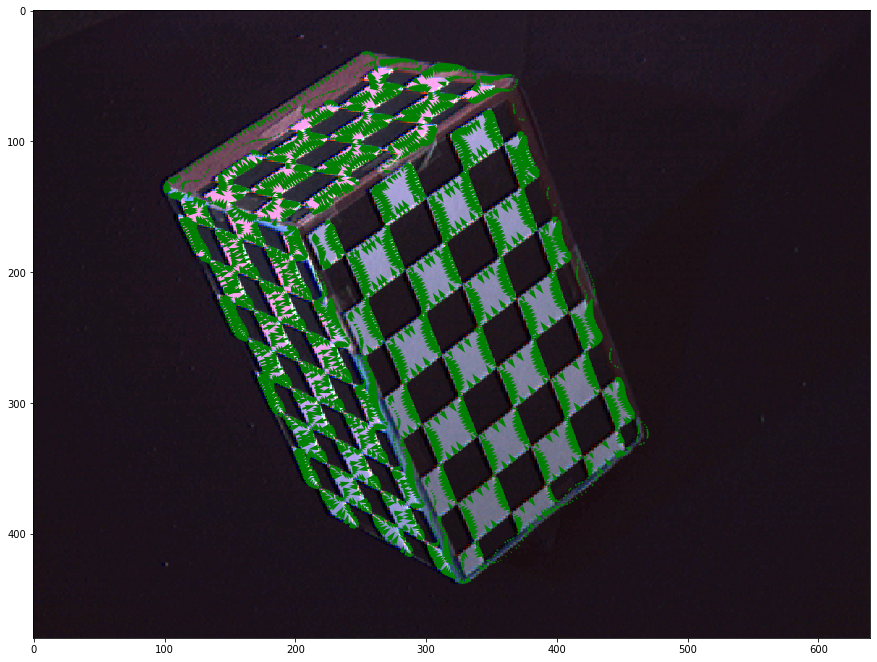

In [26]:
im = cv2.imread('./data/calib_right.bmp')
sigma = 5

e, g = edgels(im, sigma)

plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(im, cmap='gray')
plt.quiver(e[:,0], e[:,1], g[:,0], g[:,1], color='green', angles='xy')

## Question 3 (20 points)
In class we discussed a measure of "cornerness" based on the second moment matrix (also called the auto-correlation matrix),
\begin{equation*}
{\cal M}_W = \sum_{(x,y)\in W}(\nabla I(x,y))(\nabla I(x,y))^\top.
\end{equation*}

An alternative approach to corner detection is based on another matrix, the *Hessian*:
\begin{equation*}
{\cal H}=\left[\begin{array}{cc} I_{xx} & I_{xy}\\ I_{xy} & I_{yy}\\
\end{array}\right].
\end{equation*}

Like the second moment matrix, the Hessian is real and symmetric and therefore has two real eigenvalues. The eigenvalues and eigenvectors of the Hessian have a different geometric interpretation, however, and this interpretation can be seen in the figure created by running the code block below.

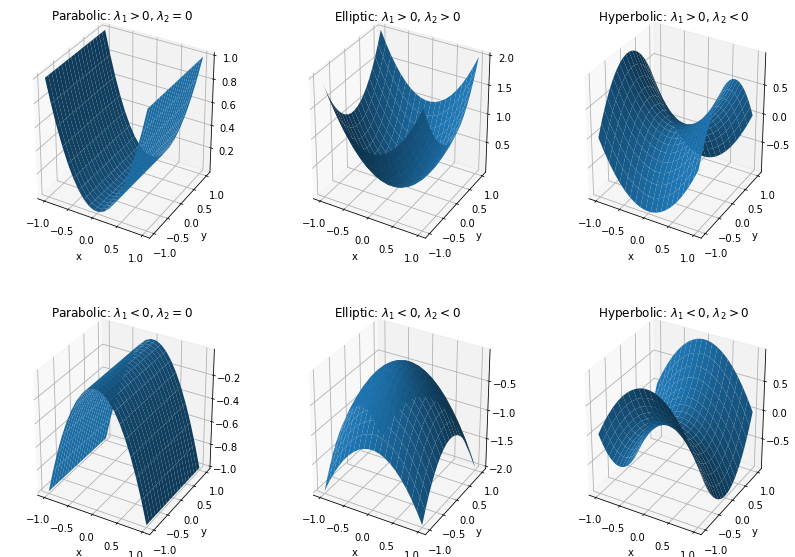

In [20]:
# Choose eigenvalues of surfaces and plot titles
lambdas = [[1.0, 0.0], [1.0, 1.0], [1.0, -1.0], [-1.0, 0.0], [-1.0, -1.0], [-1.0, 1.0]]
titles = [r'Parabolic: $\lambda_1 > 0$, $\lambda_2 = 0$',
          r'Elliptic: $\lambda_1 > 0$, $\lambda_2 > 0$',
          r'Hyperbolic: $\lambda_1 > 0$, $\lambda_2 < 0$',
          r'Parabolic: $\lambda_1 < 0$, $\lambda_2 = 0$',
          r'Elliptic: $\lambda_1 < 0$, $\lambda_2 < 0$',
          r'Hyperbolic: $\lambda_1 < 0$, $\lambda_2 > 0$']

# Define grid
x, y = np.meshgrid(np.linspace(-1.0, 1.0, 20), np.linspace(-1.0, 1.0, 20))

# Plot surfaces defined by lambda1 * x^2 + lambda2 * y^2
plt.rcParams['figure.figsize'] = [14, 10]
fig = plt.figure()
for i in range(len(lambdas)):
    lmbda = lambdas[i]
    title = titles[i]
    intensity = lmbda[0] * x ** 2 + lmbda[1] * y ** 2
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.plot_surface(x, y, intensity)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)


If we interpret the intensity function $I(x,y)$ as a surface, then the eigenvalues of ${\cal H}(x,y)$ correspond to the *principal curvatures* of the surface at the point $(x,y)$ , meaning the values of maximum and minimum curvature at that point. (The eigenvectors are orthogonal and correspond to the directions of maximum and minimum
curvature.)

The product of principal curvatures (equal to $\mbox{det}({\cal H})$) is termed the *Gaussian curvature* and their average (equal to $\frac{1}{2}\mbox{trace}({\cal H})$) is the *mean curvature*.

**a.** Use the image <tt>./data/calib_right.bmp</tt>. Convert it to a grayscale image of data type <tt>numpy.float32</tt> and display it. Assuming the mean and Gaussian curvature (denoted $H(x,y)$ and $K(x,y)$, respectively) have been computed at each point on the image plane, write an expression for "cornerness" $C(x,y)$ in terms of $H$ and/or $K$ that will yield a large response at the corners of the checker pattern and a small response elsewhere.

### Answer:

The parabolic graphs on the first column would correspond to something like edges (or rather lines) where the intensity is constant along one axis and extremized along the perpendicular axis. The elliptic graphs in the middle would correspond to salient points, where the point has a difference in intensity from everything around it. What we are looking for are the hyperbolic graphs on the right column: these have increasing intensity in two opposite directions, and decreasing intensity in the two perpendicular directions, which is exactly what one of the corner points in the checkerboard pattern looks like. 

In order to get have a hyperbolic graph, we want the product of eigenvalues of the laplacian to have a large magnitude. This ensures something approximating the first column (where one of the eigenvalues is very small) doesn't happen. Thus we want to maximize the absolute value of the Gaussian curvature. However, the middle column also has a large Gaussian curvature, so we want to account for that by considering the mean curvature. Since the mean curvature is a function of the sum of the eigenvalues, itll have a very large magnitude in the middle column in comparison with the right column, because in the middle column the eigenvalues have the same sign so they aggregate, whereas in the right column they have opposite signs so they cancel. Thus in order to get points where the image intensity locally looks like a hyperbolic surface we want to maximize the Gaussian curvature and minimize the mean curvature. This can be achieved by setting
$$C(x,y) = |K(x,y)| / (|H(x,y)| + \alpha) $$
Then a large $C(x,y)$ will correspond to a $K(x,y)$ (Gaussian curvature) that is large in magnitude and a $H(x,y)$ (mean curvature) that is small in magnitude.

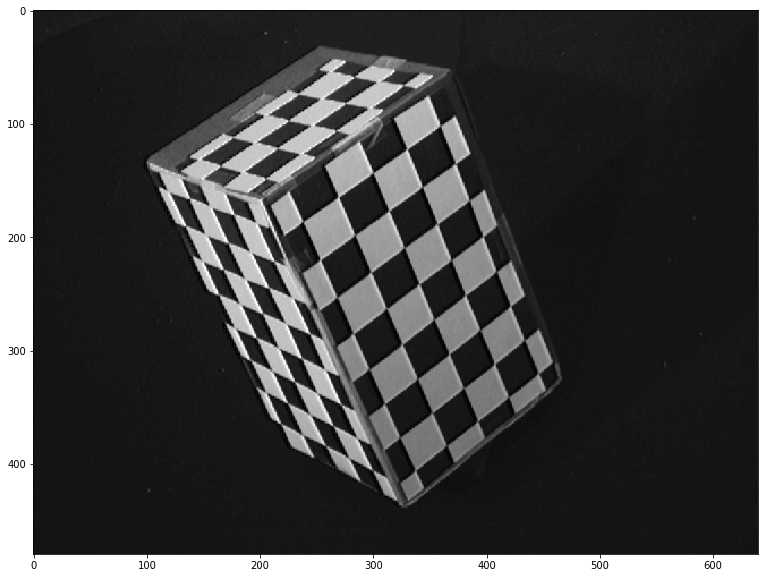

In [21]:
im = cv2.imread('./data/calib_right.bmp')
if len(im.shape) > 2 and im.shape[2] == 3:
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  
im = np.float32(im) / 255.0

plt.imshow(im, cmap='gray')

**b.** Write a function <tt>cornerness()</tt> that computes your function $C(x,y)$ from part (a) given a grayscale image <tt>im</tt> and a smoothing parameter <tt>sigma</tt> ($\sigma$) used to estimate the second derivatives of the image. It may also take other parameters you defined in part (a). This function should contain no loops. (Also, see Hints and Information below regarding discrete approximations to second derivatives.)

Run this function on the grayscale version of <tt>./data/calib_right.bmp</tt> using $\sigma=2$ and your choice of other parameters, and display the function $C(x,y)$ as a grayscale image (using the appropriate color map). Make sure to properly display $C(x, y)$, for example by rescaling it to the range $[0, 1]$ or by using the <tt>vmin</tt> and <tt>vmax</tt> inputs to <tt>matplotlib.pyplot.imshow()</tt>.

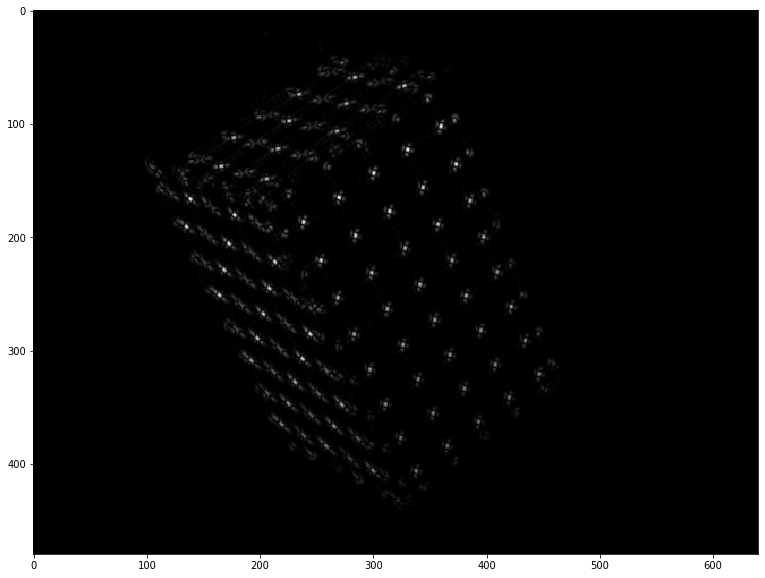

In [22]:
def cornerness(im, sigma):
    # Gaussian filter
    # Use an odd-size square window with length greater than 5 times sigma
    w = 2 * np.floor(7 * sigma / 2) + 1
    x, y = np.meshgrid(np.arange(-(w-1)/2, (w-1)/2 + 1),
                       np.arange(-(w-1)/2, (w-1)/2 + 1))
    
    r2 = x ** 2 + y ** 2  # Compute x^2 + y^2
    
    # Gaussian kernel
    G = (1 / (2 * np.pi * (sigma ** 2))) * np.exp(-r2 / (2 * sigma ** 2))
    
    # compute convolution kernels for the second order partials
    Ixx = ((x ** 2 - sigma ** 2)/(sigma ** 4)) * G
    Iyy = ((y ** 2 - sigma ** 2)/(sigma ** 4)) * G
    Ixy = (x * y / (sigma ** 4)) * G
    
    # first compute the gaussian curvature
    imGxx = scipy.signal.convolve2d(im, Ixx, 'same', boundary='symm')
    imGyy = scipy.signal.convolve2d(im, Iyy, 'same', boundary='symm')
    imGxy = scipy.signal.convolve2d(im, Ixy, 'same', boundary='symm')
    imG = imGxx * imGyy - imGxy ** 2
    
    # then compute the mean curvature
    mc = (Ixx + Iyy) / 2. 
    imM = scipy.signal.convolve2d(im, mc, 'same', boundary='symm')
    
    return np.abs(imG) / (np.abs(imM) + 0.5)

C = cornerness(im, 2)
plt.imshow(C, vmin = np.min(C), vmax = np.max(C), cmap='gray')

Wow so pretty!

**c.** Write a function <tt>nonmax_suppression(C)</tt> that returns a 2D array <tt>Co</tt> the same size as <tt>C</tt> that satisfies the following rule: $C_o(x,y)=C(x,y)$ if $C(x,y)$ is maximal in its local $3\times 3$ neighborhood, and $C_o(x,y)=0$ otherwise (see Hints and Information below about morpholotical operators, and especially dilation).

Display the grayscale version of the image <tt>./data/calib_right.bmp</tt> and superimpose a plot of the points $(x,y)$ that satisfy $C_o(x,y) > \texttt{threshold}$, where <tt>threshold</tt> is manually selected to provide a reasonable balance of false detections and missed detections. **Make sure the points are marked clearly in your submission.**

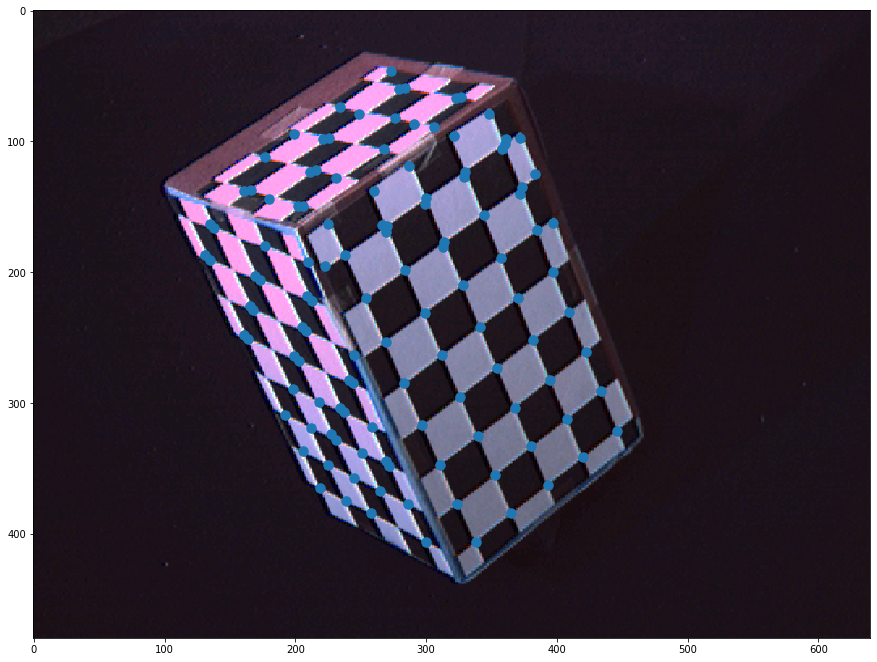

In [30]:
def nonmax_suppression(C):
    Cuint8 = cv2.convertScaleAbs(C)
    ker = np.ones((3,3), np.uint8)

    # matrix of maxima of each 3x3 neighborhood
    C0 = cv2.dilate(C, ker)
    
    # points that werent chosen as the maximum of their 3x3 
    # neighborhood should be set to 0
    C0[C != C0] = 0
    
    return C0

C0 = nonmax_suppression(C)
threshold = (2 * np.min(C0) + np.max(C0))/3

# threshold it!
C0[C0 < threshold] = 0

# now I just want to find the coordinates that achieve these local maxima
# turn C0 into an indicator for the points that achieve local maxima
C0[C0 != 0] = 1

# multiply it by the matrix of x coordiantes and by the matrix of y coordinates
C0x = C0 * np.array([range(C0.shape[1])] * C0.shape[0])
C0y = C0 * np.transpose(np.array([range(C0.shape[0])]*C0.shape[1]))

# plot the local maxima
plt.imshow(im, cmap='gray')
plt.scatter(C0x[C0 != 0], C0y[C0 != 0], s = 90)

## Question 4 (10 points)

The continuous convolution of two functions $f\left(x\right)$ and $g\left(x\right)$ is given by:
\begin{equation*}
	\left(f * g \right)\left(x\right) = \int_{-\infty}^{\infty} f\left(y\right)
g\left(x - y\right) dy.
\end{equation*}
The Gaussian function at scale $s$ is defined as:
\begin{equation*}
	G_s \left(x\right) = \frac{1}{\sqrt{2 \pi s}} \exp\left(-\frac{x^2}{2s}\right),
\end{equation*}

and has the property that:
\begin{equation*}
	\int_{-\infty}^{\infty} G_s\left(x\right) dx = 1.
\end{equation*}
Prove that this class of functions satisfies the *semigroup property*: the convolution of one Gaussian with another produces a third Gaussian with scale equal to their sum, or:
\begin{equation*}
	\left(G_{s_1} \ast G_{s_2}\right) \left(x\right) = G_{s_1 + s_2} \left(x\right).
\end{equation*}

### Answer:
The textbook says that for a Gaussian expressed as
$$G(x;\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp\left({-\frac{x^2}{2\sigma^2}}\right)$$
the Fourier transform is 
$$\frac{\sqrt{2\pi}}{\sigma}G(\omega;\sigma^{-1}) = \frac{\sqrt{2\pi}}{\sigma}\frac{1}{\frac{1}{\sigma}\sqrt{2\pi}}\exp\left(-\frac{\omega^2}{2\frac{1}{\sigma^2}}\right)$$
we note that in this expression for the Gaussian, $\sigma = \sqrt{s}$. Thus if we express our Gaussian as
$$G_s(x) = \frac{1}{\sqrt{2\pi s}}\exp\left({-\frac{x^2}{2s}}\right) $$
the Fourier transform is
$$\mathcal{F}[G_s](\omega) = \frac{\sqrt{2\pi}}{\sqrt{s}}\frac{1}{\frac{1}{\sqrt{s}}\sqrt{2\pi}}\exp\left(-\frac{\omega^2}{2\frac{1}{\sqrt{s}^2}}\right)  = \exp\left(-\frac{\omega^2}{2}s\right)$$
(we can perform this sustitution since $s, \sigma$ are not the variables that are being integrated when taking the Fourier transform so they're just scalars and we don't have to worry about change of variables)
Since the Fourier transform of the convolution is the product of the Fourier transforms, we have 
\begin{align*}
    \mathcal{F}(G_{s_1}\ast G_{s_2})(\omega) &= \exp\left(-\frac{\omega^2}{2}s_1\right)\exp\left(-\frac{\omega^2}{2}s_2\right)\\
        &= \exp\left(-\frac{\omega^2}{2}s_1 + -\frac{\omega^2}{2}s_2\right)\\
        &= \exp\left(-\frac{\omega^2}{2}(s_1+s_2)\right)\\
        &= \mathcal{F}(G_{s_1 + s_2})(\omega)
\end{align*}
Then, taking inverse Fourier transforms of both sides, we get that $G_{s_1}\ast G_{s_2} = G_{s_1 + s_2}$. 

## Hints and Information

- Robustly estimating the second derivatives of a function on a two dimensional domain is achieved by pre-filtering the function with a Gaussian kernel. Since convolution is associative, the smoothing and differentiation can be accomplished in a single step using filters that are second derivatives of a Gaussian. For example, the filter for computing the second derivative in the horizontal direction $I_{xx}$ is
\begin{equation*}
\frac{\partial^2}{\partial x^2}G(x,y;\sigma)=\left(\frac{x^2-\sigma^2}{\sigma^4}\right)G(x,y;\sigma),
\end{equation*}
where, as usual, the parameter $\sigma$ defines the "scale" of the derivative, and a discrete window width of about $5\sigma$ to $7\sigma$ is sufficient to accurately represent this continuous filter function. You should be able to write corresponding expressions for $I_{yy}$ and $I_{xy}=I_{yx}$.

- One way to think of convolution is as computing sums of weighted intensity values in a neighborhood around each pixel, with the shape of the neighborhood determined by the shape of the kernel, and the weights by its values. We can then define generalizations of convolution by replacing the sum operation with other functions. <br>
One such class of (non-linear) generalizations is *morphological operators*, where the sum is replaced by an ordinal relationship: after weighting the intensity values, compute their max, min, median, or their $k$-th largest value for any integer $k$. This last case is called *$k$-ordinal filtering*. The case of max, which is equivalent to $1$-ordinal filtering, is known as *dilation*. Finally, the case of min, equivalent to setting $k$ equal to the neighborhood size, is known as *erosion*. For more on morphological operators, you can read Section 3.3.2 of Szeliski. <br>
As with linear convolution, there are several efficient algorithms for computing morphological operators, many of which are implemented in OpenCV. Two-dimensional dilation in particular is provided by the function <tt>cv2.dilate()</tt>. You can find out more information in [OpenCV's morphological operation tutorial](http://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html).

In [25]:
a = np.array([[1,2,3,4],[5,3,11,2],[7,5,7,3]])
a = np.array([[0,1,1,4],[5,3,11,2],[7,5,7,3]], np.uint8)
ker = np.ones((3,3), np.uint8)
print(a)
b = cv2.dilate(a, ker)
b[a != b] = 0
b[b != 0] = 1
print(b)

[[ 0  1  1  4]
 [ 5  3 11  2]
 [ 7  5  7  3]]
[[0 0 0 0]
 [0 0 1 0]
 [1 0 0 0]]
